# Name : Saugat Karki
# Group Leader: Niraj Lamichhane
# Team members : Saugat Karki , Niraj Lamichhane, Rojan Shrestha , Aayush Niroula

In [31]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [32]:
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import confusion_matrix, f1_score, roc_curve, auc

# Data Understanding, Analysis, and Cleaning[5]: Understand what is data about, Perform a basic data cleaning:

In [33]:
# load the dataset
data_path="/content/drive/MyDrive/Amazon Book Review/kindle_review.csv"
df = pd.read_csv(data_path)

In [34]:
# print the first five rows of the dataset
print(df.head())

   Unnamed: 0  rating                                         reviewText  \
0           0       5  This book was the very first bookmobile book I...   
1           1       1  When I read the description for this book, I c...   
2           2       5  I just had to edit this review. This book is a...   
3           3       5  I don't normally buy 'mystery' novels because ...   
4           4       5  This isn't the kind of book I normally read, a...   

                           summary  
0                50 + years ago...  
1          Boring! Boring! Boring!  
2  Wiggleliscious/new toy ready/!!  
3                  Very good read.  
4                     Great Story!  


In [35]:
df.isnull().any()

Unnamed: 0    False
rating        False
reviewText    False
summary       False
dtype: bool

In [36]:
# perform basic cleaning tasks
df = df[['reviewText', 'rating']]
df = df.dropna()
df = df[df['rating'] != 3]
df['sentiment'] = df['rating'].apply(lambda x: 1 if x > 3 else 0)
df = df.drop(columns=['rating'])


,reviewText,rating
0,This book was the very first bookmobile book I...,5
1,"When I read the description for this book, I c...",1
2,I just had to edit this review. This book is a...,5
3,I don't normally buy 'mystery' novels because ...,5
4,"This isn't the kind of book I normally read, a...",5


In [6]:
# remove unwanted text and characters
df['reviewText'] = df['reviewText'].apply(lambda x: re.sub('[^a-zA-Z0-9\s]', '', x))


In [9]:
def remove_urls(text_series):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return text_series.apply(lambda x: url_pattern.sub(r'', x))

In [12]:
text = df['reviewText']
remove_urls(text)

0        This book was the very first bookmobile book I...
1        When I read the description for this book I co...
2        I just had to edit this review This book is an...
3        I dont normally buy mystery novels because I j...
4        This isnt the kind of book I normally read alt...
                               ...                        
11994    After E A Poe came H P Lovecraft in the world ...
11995    Had to read certain passages twicetypos  Wish ...
11997    Dragon Knights is a world where Knights ride d...
11998    Since this story is very short its hard to say...
11999    from 1922 an amazing collection of info on sym...
Name: reviewText, Length: 10000, dtype: object

In [14]:
# normalize text data
df['reviewText'] = df['reviewText'].apply(lambda x: x.lower())

# Build Model[5]:

In [37]:

# split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['reviewText'], df['sentiment'], test_size=0.2, random_state=42)


In [39]:
# tokenize and pad the sequences
tokenizer = Tokenizer(num_words=5000, oov_token='UNK')
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)
X_train_padded = pad_sequences(X_train_seq, maxlen=200)
X_test_padded = pad_sequences(X_test_seq, maxlen=200)

In [17]:
# print the shape of the cleaned and preprocessed dataset
print(X_train_padded.shape)
print(X_test_padded.shape)

(8000, 200)
(2000, 200)


In [18]:
# define the model architecture
model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=32, input_length=200))
model.add(LSTM(units=64, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(units=1, activation='sigmoid'))

# compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# print the model summary
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 32)           160000    
                                                                 
 lstm (LSTM)                 (None, 64)                24832     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 184,897
Trainable params: 184,897
Non-trainable params: 0
_________________________________________________________________
None


# Training of the Model[5]:

In [19]:
class Mycallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get("accuracy")>0.95):
      print('\nLoss is low so stop training')
      self.model.stop_training =True

In [20]:
callbacks=Mycallback()

Epoch 1/10
63/63 [==============================] - 38s 533ms/step - loss: 0.6379 - accuracy: 0.6404 - val_loss: 0.5650 - val_accuracy: 0.7715
Epoch 2/10
63/63 [==============================] - 31s 496ms/step - loss: 0.4452 - accuracy: 0.8240 - val_loss: 0.3490 - val_accuracy: 0.8650
Epoch 3/10
63/63 [==============================] - 31s 498ms/step - loss: 0.2789 - accuracy: 0.8880 - val_loss: 0.2982 - val_accuracy: 0.8800
Epoch 4/10
63/63 [==============================] - 31s 498ms/step - loss: 0.2021 - accuracy: 0.9247 - val_loss: 0.2598 - val_accuracy: 0.8965
Epoch 5/10
63/63 [==============================] - 33s 532ms/step - loss: 0.1586 - accuracy: 0.9424 - val_loss: 0.2767 - val_accuracy: 0.9010
Epoch 6/10
63/63 [==============================] - ETA: 0s - loss: 0.1277 - accuracy: 0.9570
Loss is low so stop training
63/63 [==============================] - 31s 500ms/step - loss: 0.1277 - accuracy: 0.9570 - val_loss: 0.2720 - val_accuracy: 0.9000


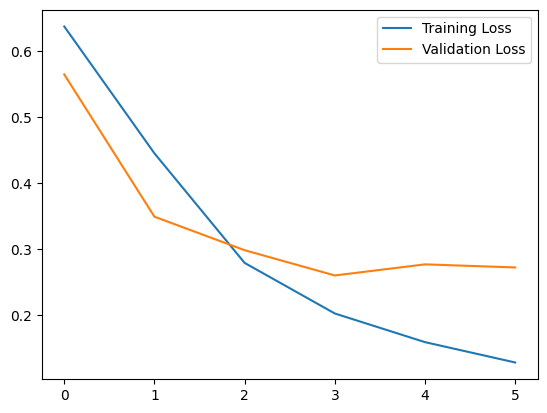

In [21]:
# train the model
history = model.fit(X_train_padded, y_train, epochs=10, batch_size=128, validation_data=(X_test_padded, y_test), callbacks=[callbacks])

# plot the training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

# Evaluate the model[2.5]:

In [22]:
# evaluate the model
loss, accuracy = model.evaluate(X_test_padded, y_test, verbose=0)
print('Test Loss:', loss)
print('Test Accuracy:', accuracy)

Test Loss: 0.27198123931884766
Test Accuracy: 0.8999999761581421


In [26]:
# get the predicted labels
y_pred = model.predict(X_test_padded)
y_pred = [round(pred[0]) for pred in y_pred]

# create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# print the confusion matrix
print(cm)

63/63 [==============================] - 5s 80ms/step
[[ 705  124]
 [  76 1095]]


In [28]:
# get the predicted probabilities
y_prob = model.predict(X_test_padded)

# get the predicted labels
y_pred = [round(prob[0]) for prob in y_prob]

# calculate the F1 score
f1 = f1_score(y_test, y_pred)

# print the F1 score
print('F1 score:', f1)

63/63 [==============================] - 2s 34ms/step
F1 score: 0.9163179916317991


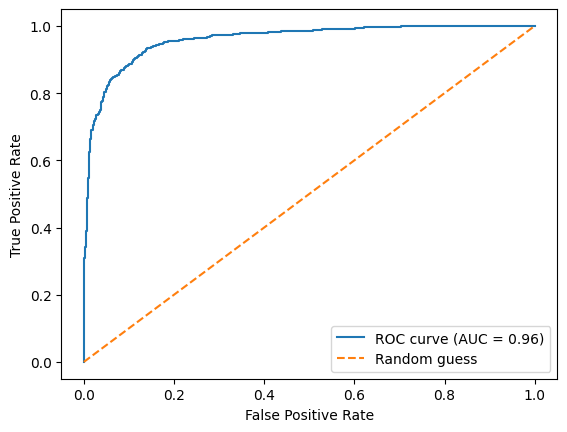

In [29]:
# calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# calculate the AUC score
auc_score = auc(fpr, tpr)

# plot the ROC curve
plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % auc_score)
plt.plot([0, 1], [0, 1], linestyle='--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

# Results and Prediction[2.5]:

In [23]:
# make predictions on the test set
y_pred = model.predict(X_test_padded)
y_pred = [round(pred[0]) for pred in y_pred]

# print the first 10 true and predicted labels
print('True labels:', list(y_test)[:10])
print('Predicted labels:', y_pred[:10])


63/63 [==============================] - 2s 35ms/step
True labels: [1, 1, 1, 0, 1, 0, 0, 0, 1, 1]
Predicted labels: [1, 1, 1, 0, 1, 0, 1, 0, 1, 0]


In [40]:
neg_review = ["I bought this set and returned it.  I couldn't force myself to finish the first book, A Touch of Silk.  ( They are bundled out of order, too).  The writing and phrasing was so immature that I thought at first it was a satire!  But the pages and pages of supposedly erotic fantasy stuffing the book to bring up the word count was the final blow.  No character development, not enough background.  What should have been interesting read like a pre- teen fantasy.  Don't waste your money."]

In [41]:
# Let's tokenize it and do the pad_sequence to make it in right format acceptable by model
neg_review_token = tokenizer.texts_to_sequences(neg_review)

# padding
neg_review_padded = pad_sequences(neg_review_token,maxlen=100,padding='post')

In [42]:
review_predict = (model.predict(neg_review_padded)>0.5).astype('int32')

1/1 [==============================] - 1s 613ms/step


In [43]:
# 1 is Positive review and 0 is negative review
if review_predict[0] == 0:
    print("It's a negative review")
else:
    print("It's a positive review")

It's a negative review


In [44]:
pos_review = ["This book was the very first bookmobile book I bought when I was in the school book club. I loved the story then and I bet a dollar to a donut I will love it again. If my memory serves, I bought this book in 5th grade. That would have been about 1961. I am looking forward to reliving the memories."]

In [45]:
# Tokenization
pos_review = tokenizer.texts_to_sequences(pos_review)

# padding
pos_review = pad_sequences(pos_review,maxlen=100,padding='post')

# prediction
review_predict = (model.predict(pos_review)>0.5).astype('int')

if review_predict[0] == 0:
    print("It's a negative review")
else:
    print("It's a positive review")

1/1 [==============================] - 0s 53ms/step
It's a positive review
